# Análise Exploratória de Dados Logísticos: Desafios e Soluções para a Loggi

# 1\. Introdução 

## 1\.1\. Contexto 


A Loggi é uma startup brasileira de tecnologia especializada em logística. Começou em 2013 entregando documentos, expandindo para e-commerce em 2016 e, desde 2017, atua também na entrega de alimentos. Assim como outras empresas do setor, a Loggi enfrenta desafios em áreas metropolitanas, onde a distribuição de entregas é desigual e a geografia complexa das cidades adiciona dificuldades.

Os dados desta análise vêm do repositório Loggi Benchmark for Urban Deliveries (BUD), que inclui conjuntos de dados e scripts de benchmark para problemas logísticos típicos, como a otimização de rotas e a alocação de entregas em veículos com capacidade limitada. Esses dados, sintetizados de fontes públicas (IBGE, IPEA, etc.), refletem os desafios enfrentados pela Loggi, especialmente em termos de escala.

Na presente análise, meu objetivo é investigar as questões de logística enfrentadas pelos hubs regionais da Loggi, utilizando os dados disponibilizados da região de Brasília. Pretendo obter insights valiosos sobre as rotas de entrega atuais e sugerir soluções para torná-las mais eficientes e ágeis. Ao explorar os dados logísticos, busco entender como os desafios enfrentados impactam a eficiência das entregas e encontrar maneiras práticas de melhorá-las, contribuindo assim para a otimização das operações de entrega da Loggi.

Este estudo não apenas aborda os problemas atuais de logística, mas também propõe uma abordagem prática para melhorar a eficiência dos hubs de distribuição e equilibrar a carga de trabalho entre eles. Com base nos dados analisados, espero fornecer recomendações detalhadas e viáveis que possam ser implementadas para aprimorar as operações logísticas da Loggi em Brasília e, potencialmente, em outras regiões atendidas pela empresa.


<center>
<img loading="lazy" src="https://t.ctcdn.com.br/0SZ3Ao0cu1etJueAosC_OdMjlBM=/2000x1125/smart/i529367.jpeg" width="760" height="360"/>
    </center>

## 1\.2\. Dados 

Os dados brutos estão armazenados em um arquivo JSON contêm informações sobre uma lista de instâncias de entregas. Cada instância representa um conjunto de entregas a serem realizadas pelos veículos do hub regional, com os seguintes campos:

* name: string com o nome único da instância;
* region: string com o nome único da região do hub;
* origin: dict com a latitude e longitude da região do hub;
* vehicle_capacity: int com a soma da capacidade de carga dos veículos do hub;
* deliveries: list de dict com as entregas a serem realizadas, onde cada entrega contém:
    *     id: string com o ID único da entrega;
    *     point: dict com a latitude e longitude da entrega;
    *     size: int com o tamanho da entrega.
    
Os datasets estão disponíveis nos links:

[Loggi Benchmark for Urban Deliverie](https://github.com/loggi/loggibud/blob/master/docs/quickstart.md) <br>
[Deliveries Brasilia JSON -> Repositório André M Perez](https://github.com/andre-marcos-perez/ebac-course-utils/blob/main/dataset/deliveries.json)

<br>
Neste projeto, trabalho com geocodificação utilizando a ferramenta Nominatim, um projeto open source que mantém um serviço gratuito de geocodificação. Este serviço tem como limitação uma única consulta por segundo. Considerando que o hub (origin) possui apenas 3 geolocalizações distintas e as entregas (deliveries) totalizam 636.149, levaria cerca de 7 dias para consultar todas as entregas no servidor do Nominatim. Devido a essa restrição, é necessário instalar um servidor local utilizando Docker.

Os dados utilizados foram providenciados através do link: 

[Deliveries Geodata.CSV -> Repositório André M Perez](https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv)

# 2\. Exploração

## 2\.1\. Pacotes e Bibliotecas 

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=251dc2caf2345df3c558aede7a9e6ca04ce2e7bbe6f1859b0db9b9d444e3c38f
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import wget
import seaborn as sns
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


## 2\.2\. Carregamento dos dados

In [3]:
# Coleta de Dados

url = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json'
output_filename = 'meu_arquivo.json'

filename = wget.download(url, out=output_filename)
print(f'Arquivo salvo como: {filename}')



# Extração das informações de entregas de um arquivo json e carregando em um dict python

with open('/kaggle/working/meu_arquivo.json', mode='r', encoding='utf8') as file:
  data = json.load(file)



# Transformando o dict python em um DataFrame do pandas
deliveries_df = pd.DataFrame(data)
deliveries_df.head(10)

Arquivo salvo como: meu_arquivo.json


,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."
5,cvrp-2-df-19,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'f4b64306e4c8185fe4baf332fdfdd22e', 'p..."
6,cvrp-0-df-7,df-0,"{'lng': -47.802664728268745, 'lat': -15.657013...",180,"[{'id': '6cc90b13f3c4386580f4ca6c6799b2ed', 'p..."
7,cvrp-2-df-26,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '5d8f8d40588819594b3e28cf2993c466', 'p..."
8,cvrp-1-df-5,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': '66ccd3ae2e54b3446f5a230996394f1d', 'p..."
9,cvrp-0-df-74,df-0,"{'lng': -47.802664728268745, 'lat': -15.657013...",180,"[{'id': '44a85635558f376bb4987e18b9c8dc7', 'po..."


## 2\.3\. Normalização de Dados Aninhados

A coluna origin contém dados aninhados na estrutura do JSON. Apesar de estar dentro de um DataFrame, a estrutura original foi mantida. Tanto esta coluna quanto a coluna deliveries precisaram ser manipuladas para sair dessas estruturas complexas.

Para resolver isso, aplicarei as seguintes operações de transformação:

* Flatten (achatamento): Esta operação transforma cada chave do JSON em uma nova coluna, facilitando a manipulação e análise dos dados.
* Explode (explosão): A coluna deliveries contém uma lista de dados aninhados na estrutura do JSON. Vamos normalizar esta coluna com a operação explode, que transforma cada elemento da lista em uma linha.
* Flatten (achatamento) do resultado: Após a explosão, aplicaremos novamente a operação flatten para transformar as chaves do JSON em novas colunas, finalizando a normalização dos dados.

Essas operações irão facilitar a manipulação e análise dos dados, permitindo uma estrutura mais simples e eficiente para o trabalho.

### 2\.2\.1\. Coluna Origin

In [4]:
# Método pd.JSON_normalize separa o dado, criando uma coluna apenas para latitude e u outra apenas para longitude
hub_origin_df = pd.json_normalize(deliveries_df["origin"]) 


# O merge será o responsavel por acrescentar essa coluna ao dataframe original através do numero de indice que foi mantido
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True) 


# Manipulação para limpeza do data frame:

deliveries_df = deliveries_df.drop("origin", axis=1) 
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]] # Reorganiza cabeçalho
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True) # Renomeia as colunas

# Visualização do dado:

deliveries_df.head(10)

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."
5,cvrp-2-df-19,df-2,-48.054989,-15.838145,180,"[{'id': 'f4b64306e4c8185fe4baf332fdfdd22e', 'p..."
6,cvrp-0-df-7,df-0,-47.802665,-15.657014,180,"[{'id': '6cc90b13f3c4386580f4ca6c6799b2ed', 'p..."
7,cvrp-2-df-26,df-2,-48.054989,-15.838145,180,"[{'id': '5d8f8d40588819594b3e28cf2993c466', 'p..."
8,cvrp-1-df-5,df-1,-47.893662,-15.805118,180,"[{'id': '66ccd3ae2e54b3446f5a230996394f1d', 'p..."
9,cvrp-0-df-74,df-0,-47.802665,-15.657014,180,"[{'id': '44a85635558f376bb4987e18b9c8dc7', 'po..."


### 2\.2\.1\. Coluna Deliveries

In [5]:
# Criação um novo dataframe onde cada linha representa uma entrega individual
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")


# Normalizando as colunas size, longitude e latitude
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)


# Descarte da coluna deliveries e mesclagem de informações no DataFrame original
deliveries_df = deliveries_df.drop(columns="deliveries") 
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head(10)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055
5,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,10,-48.120448,-15.847780
6,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.121802,-15.852089
7,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,10,-48.116300,-15.851215
8,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116317,-15.849660
9,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,8,-48.123115,-15.849925


## 2\.4\. Qualidade dos Dados e Consistência do Schema


A qualidade dos dados está diretamente relacionada à consistência do seu schema, à presença de valores faltantes, entre outros aspectos. O método info() exibe informações detalhadas sobre o DataFrame, incluindo:

* Número de colunas
* Nomes das colunas
* Tipos de dados
* Uso de memória
* Intervalo de índice
* Número de linhas em cada coluna
* Valores nulos

Neste caso específico, não há valores nulos na tabela.



In [6]:
# Diminuição do arquivo gerado

# Identificar colunas com tipos de dados int64 e float64

int_cols = deliveries_df.select_dtypes(include=['int64']).columns
float_cols = deliveries_df.select_dtypes(include=['float64']).columns


# Converter colunas int64 para int32
deliveries_df[int_cols] = deliveries_df[int_cols].astype('int32')


# Converter colunas float64 para float32
deliveries_df[float_cols] = deliveries_df[float_cols].astype('float32')

In [7]:
deliveries_df.info() 

deliveries_df.isna().any() # Verificação de valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float32
 3   hub_lat           636149 non-null  float32
 4   vehicle_capacity  636149 non-null  int32  
 5   delivery_size     636149 non-null  int32  
 6   delivery_lng      636149 non-null  float32
 7   delivery_lat      636149 non-null  float32
dtypes: float32(4), int32(2), object(2)
memory usage: 24.3+ MB


name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

In [8]:
# Separar os dados numéricos dos dados categóricos

var_numericos = []
var_categoricas = []

for coluna in deliveries_df.columns:
  if deliveries_df[coluna].dtype != "object":
    var_numericos.append(coluna)
  else:
    var_categoricas.append(coluna)


deliveries_df[var_categoricas].describe().T

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [9]:
deliveries_df[var_numericos].describe().T

,count,mean,std,min,25%,50%,75%,max
hub_lng,636149.0,-47.949898,0.091875,-48.054989,-48.054989,-47.893661,-47.893661,-47.802666
hub_lat,636149.0,-15.802361,0.053463,-15.838144,-15.838144,-15.805118,-15.805118,-15.657014
vehicle_capacity,636149.0,180.000000,0.000000,180.000000,180.000000,180.000000,180.000000,180.000000
delivery_size,636149.0,5.512111,2.874557,1.000000,3.000000,6.000000,8.000000,10.000000
delivery_lng,636149.0,-47.946083,0.112769,-48.280781,-48.035912,-47.928967,-47.883392,-47.310612
delivery_lat,636149.0,-15.809491,0.082462,-16.050028,-15.842794,-15.814034,-15.769516,-15.500355


<h3> Análise dos Atributos Categóricos </h3>

Categoria "nome": A tabela contém 636.149 linhas, das quais 199 são únicas. O valor mais comum é "cvrp-1-df-87", presente em 5.636 linhas.
Categoria "regiao": A tabela contém 636.169 linhas, com apenas 3 valores únicos. O valor mais frequente é "df-1", presente em 304.708 linhas.

<h3> Análise dos Atributos Numéricos </h3>

Vehicle Capacity: Todos os valores na coluna "vehicle_capacity" são iguais a 180, indicando ausência de variação.
Delivery Size: Os valores da coluna "delivery_size" mostram variação moderada, com uma média de 5,5121, mediana de 6,0000 e desvio padrão de 2,8746. Considerando a baixa amplitude, essas variações são relativamente moderadas.

<br>

**Essas análises são fundamentais para entender a distribuição dos dados e identificar padrões ou anomalias, o que facilita a tomada de decisões informadas e a realização de ajustes necessários no processo de manipulação dos dados.**


# 3\. Manipulação e Enriquecimento dos dados

## 3\.1\. Aplicação da geocodificação reversa 

A geocodificação é o processo que transforma uma localização descrita por um texto (endereço, nome do local, etc.) em suas respectivas coordenadas geográficas (latitude e longitude). A geocodificação reversa realiza a operação oposta, convertendo coordenadas geográficas em descrições textuais.

Neste projeto, criei o DataFrame intitulado "hub_geodata_df", que contém informações de cidade e bairro. Realizei a limpeza e o preenchimento de valores faltantes, garantindo que as colunas hub_city e hub_suburb fossem preenchidas com base em hub_town, quando necessário.

Em seguida, combinei o DataFrame hub_geodata_df com o DataFrame principal deliveries_df, enriquecendo os dados com informações adicionais de localidade. Esses procedimentos garantiram que as informações de geocodificação fossem precisas e completas, melhorando a qualidade e a utilidade dos dados para análise e tomada de decisões.



In [10]:
# Seleciona colunas de interesse, remove duplicidade, ordena o dataframe e redefine os índices
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True) 

# Cria um objeto Nominatim com um nome de usuário definido
geolocator = Nominatim(user_agent="ebac_geocoder")

# Obtem informações do local a partir de suas coordenadas
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")


# Exibe as informações formatadas em JSON
print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 46082661,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.0533433333333333,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-127, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "state

### 3\.1\.1\. Coluna Origin

In [11]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

# Criação de coluna geodata para armezenamento das coordenadas
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder) # Aplica a função ao longo do dataframe

# Normalização e transformação dos dados em colunas
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))

# Seleção das colunas de interesse
hub_geodata_df_treated = hub_geodata_df.copy()
hub_geodata_df_treated[["address.town", "address.suburb", "address.city"]]
hub_geodata_df_treated.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True) # Renomeia as colunas

# Aqui a função np.where é utilizada para preencher valores faltantes na coluna hub_city.
hub_geodata_df_treated["hub_city"] = np.where(hub_geodata_df_treated["hub_city"].notna(), hub_geodata_df_treated["hub_city"], hub_geodata_df_treated["hub_town"])
hub_geodata_df_treated["hub_suburb"] = np.where(hub_geodata_df_treated["hub_suburb"].notna(), hub_geodata_df_treated["hub_suburb"], hub_geodata_df_treated["hub_city"])
hub_geodata_df_treated = hub_geodata_df_treated.drop("hub_town", axis=1)

# Mesclagem dos dataframes 
hub_df = pd.merge(left=hub_df, right=hub_geodata_df_treated, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]

deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head(10)

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,9,-48.116188,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,1,-48.112484,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,7,-48.114899,-15.858054
5,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,10,-48.120449,-15.847780
6,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,7,-48.121803,-15.852089
7,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,10,-48.116299,-15.851215
8,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,9,-48.116318,-15.849660
9,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,8,-48.123116,-15.849925


### 3\.1\.2\. Coluna Deliveries

Enquanto o hub contém apenas 3 geolocalizações distintas, as entregas somam o total de 636.149, o que levaria em torno de 7 dias para serem consultadas no servidor do Nominatim. Dada a restrição de uma consulta por segundo, os dados utilizados foram providenciados através do link: [Deliveries Geodata.CSV -> Repositório André M Perez](https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv)

In [12]:
url = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv'
output_filename = 'deliveries-geodata.csv'

filename = wget.download(url, out=output_filename)

deliveries_geodata_df = pd.read_csv('/kaggle/working/deliveries-geodata.csv')
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[['delivery_city', 'delivery_suburb']], how='inner', left_index=True, right_index=True)

# Conversão de 64Bits para 32Bits
int_cols = deliveries_df.select_dtypes(include=['int64']).columns
float_cols = deliveries_df.select_dtypes(include=['float64']).columns
deliveries_df[int_cols] = deliveries_df[int_cols].astype('int32')
deliveries_df[float_cols] = deliveries_df[float_cols].astype('float32')


deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,9,-48.116188,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,1,-48.112484,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838144,Taguatinga,Taguatinga,180,7,-48.114899,-15.858054,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


## 3\.2\. Schema da geocodificação 

Ao realizar a análise da coluna delivery_city em porcentagem, observei que o valor encontrado foi de 0,26%. Esse valor, relativamente baixo, indica que está dentro do esperado e não apresenta preocupações imediatas. No entanto, ao examinar os dados, notei um problema específico relacionado à cidade de Brasília. Brasília, na realidade, é composta por diversas regiões administrativas, e essa agregação pode prejudicar a precisão das análises e interpretações dos dados, especialmente se houver diferenças significativas na entrega de produtos entre essas regiões. Assim, recomendo a desagregação da cidade de Brasília em suas respectivas regiões administrativas para obter uma visão mais detalhada e precisa dos dados de entrega.

Na análise da coluna delivery_suburb, identifiquei que 25,13% dos registros possuem valores faltantes. Esse percentual elevado pode ser prejudicial, pois uma grande quantidade de dados ausentes pode comprometer a integridade das análises. Além disso, a análise da coluna entrega_bairro revelou a presença de bairros inexistentes, como o bairro de Brasília. Embora esses registros correspondam a uma pequena porcentagem do total de entregas, eles podem ainda assim distorcer os resultados. Diferenças significativas nas entregas para esses bairros inexistentes em comparação com os bairros reais podem levar a conclusões equivocadas. Por isso, é importante considerar a correção ou exclusão desses registros para garantir a precisão das análises.

In [13]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float32
 3   hub_lat           636149 non-null  float32
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int32  
 7   delivery_size     636149 non-null  int32  
 8   delivery_lng      636149 non-null  float32
 9   delivery_lat      636149 non-null  float32
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float32(4), int32(2), object(6)
memory usage: 43.7+ MB


In [14]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [15]:
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

0.26754738276724477

In [16]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

In [17]:
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
Name: count, dtype: float64

In [18]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
Name: count, dtype: float64

# 4\. Visualização dos dados

Irei fazer o download dos dados do mapa do Distrito Federal do site oficial do IBGE através do seguinte [link](https://www.ibge.gov.br/geociencias/cartas-e-mapas/bases-cartograficas-continuas) para criar o DataFrame `mapa`. 

In [19]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps 
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

# Mapa do Distrito Federal
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]

# Mapa dos Hubs
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))

# Mapa das entregas
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))

**Mapa de entregas por região**

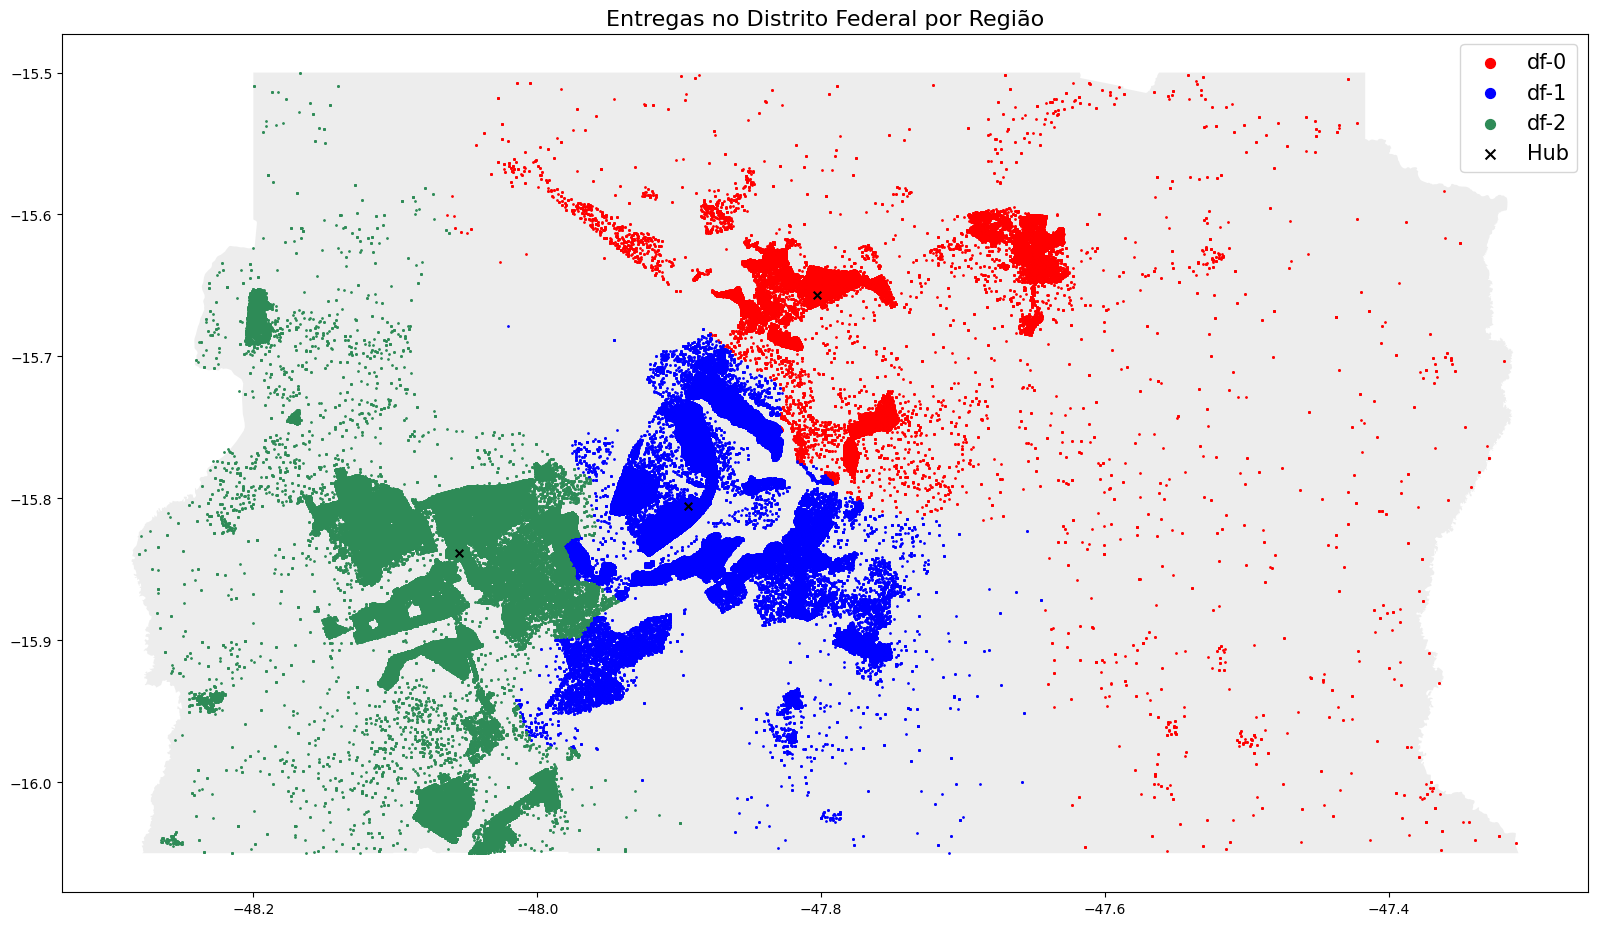

In [20]:
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="Hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legend_handles:
    handle.set_sizes([50])

**Gráfico de entregas por região**

In [21]:
data = deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True).reset_index(name='region_percent')
data.head()


,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


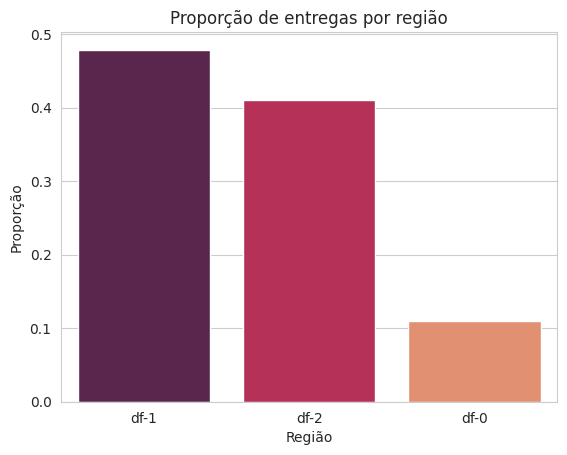

In [22]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", errorbar=None, palette="rocket")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

# 5\. Insights

Com base nas tabelas e nos graficos gerados, foi elaborado o seguinte insight:

1.	Concentração de Entregas e Densidade Regional

* Região df1 (Central de Brasília): A região df1, situada no centro de Brasília, é altamente densa e concentrada, com um hub localizado na Asa Sul que também atende as regiões do Lago Norte e Lago Sul. A alta densidade nesta área implica em menor distância entre as entregas, tornando o processo mais eficiente em termos de tempo e custo.
* Região df0 (Taguatinga, Ceilândia e Zona Rural): Em contraste, a região df0, que abrange Taguatinga, Ceilândia e a zona rural de Brasília, é menos concentrada, com entregas mais espalhadas. Isso aumenta as distâncias entre as entregas, elevando o tempo e os custos logísticos.
* Região df2 (Sul, Recanto das Emas): A região df2, localizada ao sul apresenta uma característica híbrida: alta concentração em áreas pequenas e pontos de entrega espalhados. A proximidade com Goiás sugere a necessidade de atenção especial às entregas interestaduais, devido aos diferentes regulamentos e distâncias maiores.

2.	Localização dos Hubs

* A localização dos hubs, em geral, está bem posicionada. No entanto, algumas regiões fronteiriças podem apresentar confusões na alocação das entregas, indicando a necessidade de ajustes na definição das áreas de atendimento de cada hub para evitar sobreposição de regiões e melhorar a eficiência. 

3.	Capacidade dos Veículos

* Todos os veículos possuem a mesma capacidade de carga, o que pode não ser ideal para regiões com diferentes densidades de entrega. Por exemplo, veículos menores podem ser mais eficientes em áreas de alta densidade, como a região df1, enquanto veículos maiores ou com maior autonomia podem ser mais adequados para áreas mais espalhadas, como as regiões df0 e df2.


<h3> Propostas de Resolução </h3>

1.	Otimização de Rotas

* Região df1: Para a otimização de rotas na região df1, é recomendável utilizar algoritmos de otimização, como o algoritmo de Clarke-Wright. Esse algoritmo ajuda a minimizar a distância total percorrida e o tempo das entregas, aproveitando a alta densidade da região para consolidar rotas de maneira eficiente. 
* Região df0: Na região df0, onde as entregas são mais dispersas, seria benéfico implementar roteirização dinâmica que ajuste as rotas em tempo real, considerando o tráfego e as condições das estradas. Além disso, a utilização de pontos de parada intermediários pode ajudar a reduzir a distância entre as entregas, otimizando o tempo de entrega.
* Região df2: Na região df2, uma combinação de roteirização fixa para áreas densas e roteirização dinâmica para pontos espalhados pode ser mais eficiente. É crucial considerar rotas interestaduais eficientes, especialmente para as áreas próximas a Goiás, para garantir entregas oportunas e econômicas.

2.	Alocação de Entregas e Veículos

* Revisar a capacidade dos veículos é essencial. Veículos menores devem ser alocados para áreas de alta densidade, como a região df1, para garantir que possam navegar mais facilmente em áreas congestionadas e realizar mais entregas em menos tempo. Para áreas mais dispersas, como as regiões df0 e df2, veículos maiores ou com maior autonomia são mais adequados, pois podem transportar mais mercadorias em uma única viagem, reduzindo o número de viagens necessárias e, consequentemente, os custos.
* Implementar um sistema de gerenciamento de frotas que permita a redistribuição dinâmica de veículos com base na demanda em tempo real.

3.	Ajuste na Localização dos Hubs

* Realizar uma análise geoespacial detalhada para identificar possíveis reposicionamentos dos hubs, especialmente nas regiões fronteiriças. Isso pode incluir a criação de sub-hubs ou pontos de consolidação temporários para melhorar a cobertura e eficiência.
* Considerar a possibilidade de hubs móveis ou temporários durante períodos de alta demanda pode ajudar a reduzir a carga sobre os hubs fixos, garantindo que todas as áreas sejam atendidas de maneira eficaz.


<h3> Conclusão </h3>

A análise detalhada do gráfico e dos dados sugere que, embora a alocação atual dos hubs seja em grande parte eficiente, existem oportunidades significativas para otimização das rotas e alocação de veículos. A implementação de tecnologias de roteirização avançada e um sistema de gerenciamento de frotas dinâmico pode melhorar significativamente a eficiência logística, reduzindo custos e tempos de entrega. Além disso, ajustes na capacidade dos veículos e a localização dos hubs podem proporcionar maior flexibilidade e capacidade de resposta às variações na demanda e nas condições das entregas.
